# Chapter 2: More Models And Bigger Dataset

As we discovered earlier, it seems that our lack of data and balance seems to be affecting our results, thus we moved to a different, bigger dataset to circumvent this issue.

We will try a bit of logistic to see how it fares compared to the original dataset in Chapter 1, then switch to SVM, which typically performs the same task better.

We will also keep note of the significant features here, to see if there is consistency among different datasets or not, or if there are perhaps other features of greater importance compared to other datasets. That is since we want to extract our own features from voice, and want to see which features were most relevant in other datasets, before testing on our own.

We will need to import all the useful libraries we needed in the previous chapter, so we import them as our first step

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score, mean_squared_error, mean_absolute_error,r2_score,accuracy_score, classification_report, confusion_matrix,roc_curve, auc, roc_auc_score, precision_recall_curve,average_precision_score, log_loss, brier_score_loss
n_job = 6 # Adjust  to your machine, less = less load, each n is a core

Since column names are not natively provided, we will include them manually, they are provided in the source of the dataset at:

 (https://archive.ics.uci.edu/dataset/301/parkinson%2Bspeech%2Bdataset%2Bwith%2Bmultiple%2Btypes%2Bof%2BAudio%2Brecordings)

In [71]:

# Define column names
columns = [
    "Subject_id",
    # Jitter features
    "Jitter_local", "Jitter_local_absolute", "Jitter_rap", "Jitter_ppq5", "Jitter_ddp",
    # Shimmer features
    "Shimmer_local", "Shimmer_local_dB", "Shimmer_apq3", "Shimmer_apq5", "Shimmer_apq11", "Shimmer_dda",
    # Other features
    "AC", "NTH", "HTN",
    # Pitch features
    "Median_pitch", "Mean_pitch", "Std_pitch", "Min_pitch", "Max_pitch",
    # Pulse/period features
    "Num_pulses", "Num_periods", "Mean_period", "Std_period",
    # Voice break features
    "Frac_unvoiced_frames", "Num_voice_breaks", "Degree_voice_breaks",
    # UPDRS and class
    "UPDRS", "Class"
]

# Read dataset with headers
df_train = pd.read_csv("train_data.txt", header=None, names=columns)

print(df_train.head())
print(df_train.shape)


   Subject_id  Jitter_local  Jitter_local_absolute  Jitter_rap  Jitter_ppq5  \
0           1         1.488               0.000090       0.900        0.794   
1           1         0.728               0.000038       0.353        0.376   
2           1         1.220               0.000074       0.732        0.670   
3           1         2.502               0.000123       1.156        1.634   
4           1         3.509               0.000167       1.715        1.539   

   Jitter_ddp  Shimmer_local  Shimmer_local_dB  Shimmer_apq3  Shimmer_apq5  \
0       2.699          8.334             0.779         4.517         4.609   
1       1.059          5.864             0.642         2.058         3.180   
2       2.196          8.719             0.875         4.347         5.166   
3       3.469         13.513             1.273         5.263         8.771   
4       5.145          9.112             1.040         3.102         4.927   

   ...  Max_pitch  Num_pulses  Num_periods  Mean_period 

### Preprocessing Data

We will now aim to clean the dataset from any redundancy like we did previously

Our goal is to get X and y sets, for training and tesing respectively, that do not cause issues with each other, don't generate data leakage, and have the best feature set possible

We will need to train to find the truly optimal training set, but for now we are content with reducing redundancy in the preprocessing stage

We first notice that the dataset is already split into test set and training set, we will merge the 2 sets into one and split in the fashion needed to get good results when training

We first label the test set like we did for train:

In [72]:

# Define column names
columns = [ # Note no UPDRS in test set
    "Subject_id",
    # Jitter features
    "Jitter_local", "Jitter_local_absolute", "Jitter_rap", "Jitter_ppq5", "Jitter_ddp",
    # Shimmer features
    "Shimmer_local", "Shimmer_local_dB", "Shimmer_apq3", "Shimmer_apq5", "Shimmer_apq11", "Shimmer_dda",
    # Other features
    "AC", "NTH", "HTN",
    # Pitch features
    "Median_pitch", "Mean_pitch", "Std_pitch", "Min_pitch", "Max_pitch",
    # Pulse/period features
    "Num_pulses", "Num_periods", "Mean_period", "Std_period",
    # Voice break features
    "Frac_unvoiced_frames", "Num_voice_breaks", "Degree_voice_breaks",
    # UPDRS and class
    "Class"
]

# Read dataset with headers
df_test = pd.read_csv("test_data.txt", header=None, names=columns) #For train set

print(df_test.head())
print(df_test.shape)


   Subject_id  Jitter_local  Jitter_local_absolute  Jitter_rap  Jitter_ppq5  \
0           1         0.135               0.000007       0.067        0.078   
1           1         0.143               0.000007       0.073        0.081   
2           1         0.162               0.000008       0.087        0.089   
3           1         0.140               0.000007       0.075        0.089   
4           1         0.150               0.000007       0.080        0.097   

   Jitter_ddp  Shimmer_local  Shimmer_local_dB  Shimmer_apq3  Shimmer_apq5  \
0       0.202          2.033             0.178         1.074         1.336   
1       0.219          1.236             0.107         0.612         0.904   
2       0.260          1.338             0.117         0.630         0.948   
3       0.224          1.086             0.094         0.556         0.747   
4       0.240          1.049             0.091         0.533         0.698   

   ...  Min_pitch  Max_pitch  Num_pulses  Num_periods  M

The dataset provider says on the website that it can be assumed the test dataset is independent from training dataset, so we wil consider their subject IDs independent of the train set

We will merge the two sets as follows:

In [73]:
df_test['Subject_id'] = df_test['Subject_id'] + df_train['Subject_id'].nunique() # Consider subject ID in train independent from those in test
#To combine properly drop UDPRS from train, we won't need it anyway
df_train = df_train.drop(columns=["UPDRS"]) #UPDRS is just a score for how severe the disease is, obviously dont want that in our dataset, as we only care about class for detection,
                                            #and won't work as feature

#Combine datasets
df = pd.concat([df_train, df_test], ignore_index=True)
print(df.head())

#Print the counts of 'yes' vs 'no' in the class column to see balance
print("Label counts:")
print(df['Class'].value_counts())

#Print the number of unique IDs to know how many group splits
print("\nNumber of unique patient IDs:")
print(df['Subject_id'].nunique())
print(df.shape)

   Subject_id  Jitter_local  Jitter_local_absolute  Jitter_rap  Jitter_ppq5  \
0           1         1.488               0.000090       0.900        0.794   
1           1         0.728               0.000038       0.353        0.376   
2           1         1.220               0.000074       0.732        0.670   
3           1         2.502               0.000123       1.156        1.634   
4           1         3.509               0.000167       1.715        1.539   

   Jitter_ddp  Shimmer_local  Shimmer_local_dB  Shimmer_apq3  Shimmer_apq5  \
0       2.699          8.334             0.779         4.517         4.609   
1       1.059          5.864             0.642         2.058         3.180   
2       2.196          8.719             0.875         4.347         5.166   
3       3.469         13.513             1.273         5.263         8.771   
4       5.145          9.112             1.040         3.102         4.927   

   ...  Min_pitch  Max_pitch  Num_pulses  Num_periods  M

We notice now that the class 0/1 split is uneven, with approximately 57% class 1 and 43% class 0, so we will aim to use stratified group splitting to split by groups to avoid data leakage, and to be balanced in classes as to not produced skewed train/test split that may distort metrics.

We will now work on splitting to X and y sets and eliminating redundancy:


Feature correlations with Parkinson's status:
HTN                       0.232
AC                        0.221
Num_periods               0.086
Num_pulses                0.079
Mean_period               0.077
Jitter_local_absolute     -0.000
Jitter_ppq5               -0.007
Min_pitch                 -0.008
Jitter_rap                -0.016
Jitter_ddp                -0.016
Shimmer_apq11             -0.032
Jitter_local              -0.054
Median_pitch              -0.072
Mean_pitch                -0.102
Shimmer_apq3              -0.135
Shimmer_dda               -0.135
Num_voice_breaks          -0.142
Shimmer_apq5              -0.143
Shimmer_local             -0.153
Std_period                -0.154
Shimmer_local_dB          -0.163
Std_pitch                 -0.188
Max_pitch                 -0.191
NTH                       -0.203
Degree_voice_breaks       -0.210
Frac_unvoiced_frames      -0.254


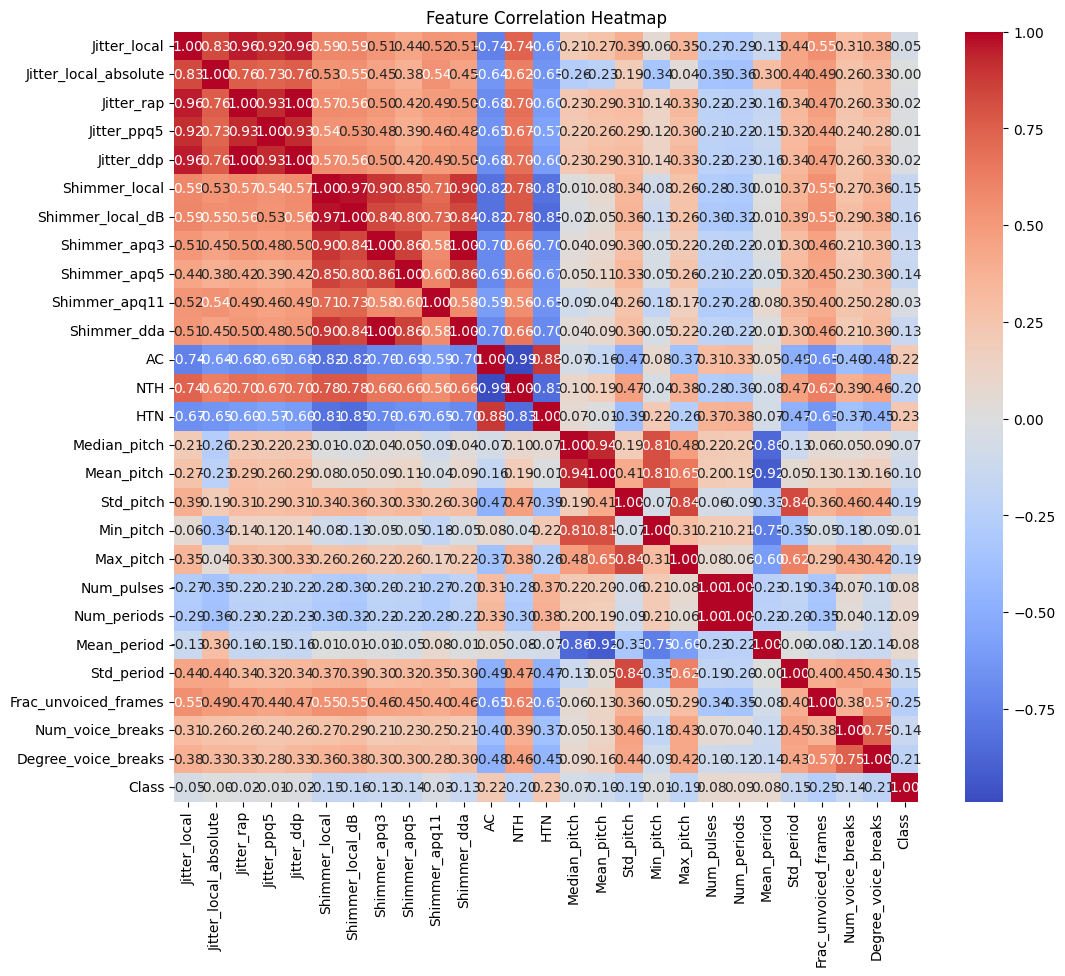

In [74]:
#find correlation between status and variables
corr = df.drop(columns=["Subject_id"]).corr()["Class"].sort_values(ascending=False)

print("\nFeature correlations with Parkinson's status:")
for feature, value in corr.drop("Class").items():
    print(f"{feature:25s} {value:.3f}")


#plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop(columns=["Subject_id"]).corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [75]:
X = df.drop(columns=["Subject_id", "Class"])
y = df["Class"]
groups = df["Subject_id"]

# Find correlation between Class and variables
corr = df.drop(columns=["Subject_id"]).corr()["Class"].sort_values(ascending=False)

print("\nFeature correlations with Parkinson's status:")
for feature, value in corr.drop("Class").items():
    print(f"{feature:25s} {value:.3f}")



Feature correlations with Parkinson's status:
HTN                       0.232
AC                        0.221
Num_periods               0.086
Num_pulses                0.079
Mean_period               0.077
Jitter_local_absolute     -0.000
Jitter_ppq5               -0.007
Min_pitch                 -0.008
Jitter_rap                -0.016
Jitter_ddp                -0.016
Shimmer_apq11             -0.032
Jitter_local              -0.054
Median_pitch              -0.072
Mean_pitch                -0.102
Shimmer_apq3              -0.135
Shimmer_dda               -0.135
Num_voice_breaks          -0.142
Shimmer_apq5              -0.143
Shimmer_local             -0.153
Std_period                -0.154
Shimmer_local_dB          -0.163
Std_pitch                 -0.188
Max_pitch                 -0.191
NTH                       -0.203
Degree_voice_breaks       -0.210
Frac_unvoiced_frames      -0.254


### Removing Redundancy

As noted in the previous dataset, there's a lot of redundancy as apparent with the ver high correlation between some features, we will aim to eliminate those features and see what we get for remainign features:

**Jitter family (timing perturbation) they all carry the same info**

DDP = 3 * RAP; 'absolute' is just a unit change of 'local'

So we will drop:
"Jitter_local_absolute", "Jitter_rap", "Jitter_ppq5", "Jitter_ddp",

**Shimmer family (amplitude perturbation)**

DDA = 3 * APQ3; dB is just a log-scaled duplicate of percent;

APQ3 & APQ5 are highly collinear with Shimmer_local, since Shimmer_apq3 ≈ Shimmer_local smoothed over 3 cycles, they essentially capture the same underlying jitter in amplitude, just with minor temporal smoothing.

With apq11 and local, we will capture all we need essentiaally without fear of overfitting on shimmer

So we will drop:

"Shimmer_local_dB", "Shimmer_apq3", "Shimmer_apq5", "Shimmer_dda",

**Pitch/period & counting proxies, mathematical or duration-driven duplicates**
Num of periods and Num of pulse measure the same thing (thus the 1 correlation) we will drop 1 as follows:

"Num_pulses"

**Noise/harmonics block, AC tracks NTH/HTN very tightly**

So we will drop:

"AC"

We also know since NTH Quantifies the ratio of noise energy to harmonic energy, while HTN is the complete inverse, we can keep only 1 to capture the full relation ship, we will keep HTN as it's in a stable logarithmic scale, as it is measuered in dB which compresses wide differences to a log scale.

So we will drop:
"NTH"


**Period and Pitch**
Period = 1/pitch, so it is better we drop them as the general trend regarding them will be caught with only one of the two

So we will drop:

"Mean period", "Std_period"

Also num_periods scales with mean pitch due to period = 1/pitch, so no need to keep as well:

"Num_periods"

We will proceed to drop what we found to be redundant:

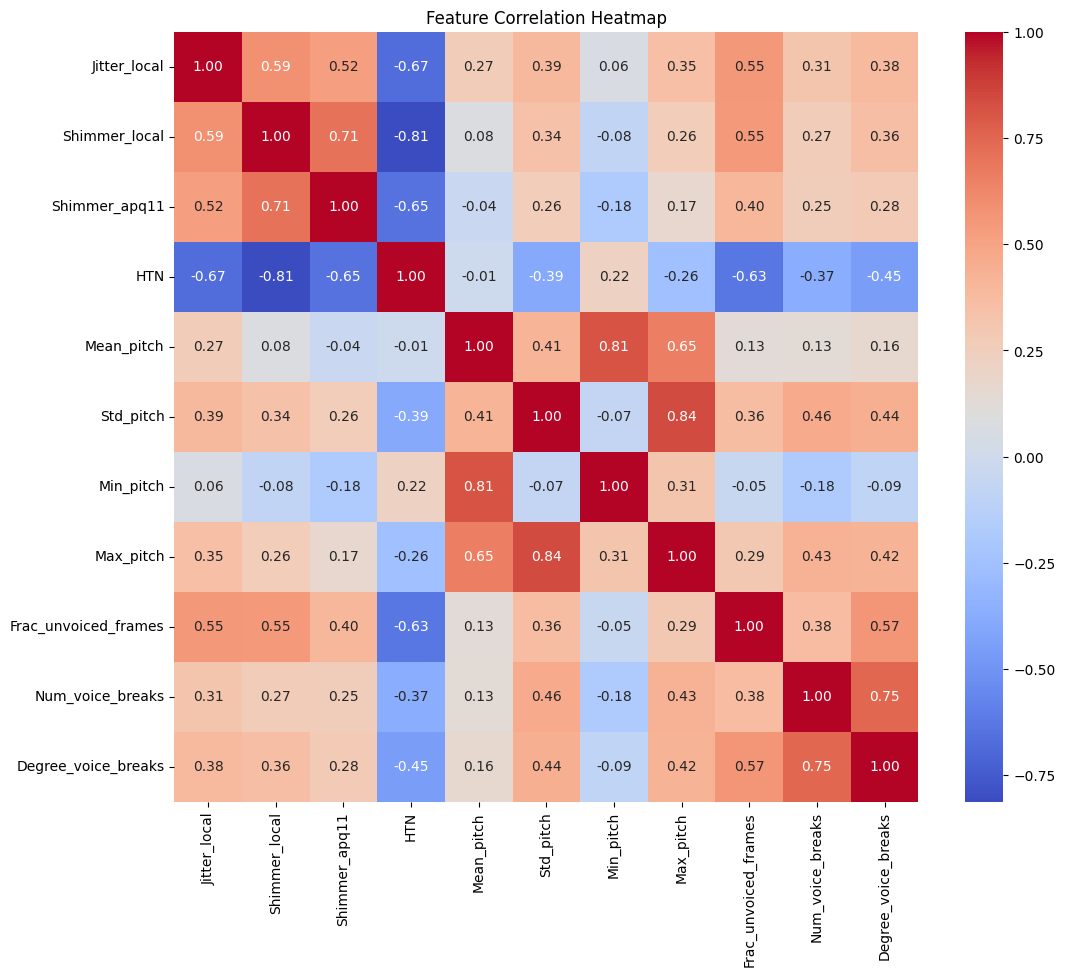

In [76]:
redundant = [
    # Jitter redundancy
    "Jitter_local_absolute", "Jitter_rap", "Jitter_ppq5", "Jitter_ddp",
    # Shimmer redundancy
    "Shimmer_local_dB", "Shimmer_apq3", "Shimmer_apq5", "Shimmer_dda",
    # Period & pitch redundancy
    "Mean_period", "Std_period", "Median_pitch",
    # Counting proxies
    "Num_pulses", 
    # Noise/harmonics redundancy
    "AC", "NTH",
    # Optional: drop duration proxy if variable length
    "Num_periods"
]
X = X.drop(columns=redundant)


#plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

We observe, the shape and nature of our X now:

In [77]:
print(f"X has {X.shape[1]} features and {X.shape[0]} samples.")
print(f"y contains {(y == 0).sum()} healthy (0) and {(y == 1).sum()} Parkinson's (1) samples.")

X has 11 features and 1208 samples.
y contains 520 healthy (0) and 688 Parkinson's (1) samples.


We observe, that our data here is much more balanced than the last data set. We will now work on training a model using these features:

# Section 2: Model Fitting
# Trial One, Revisiting Logistic Regression
______________________________________________________________________________________________________________________________________________________

We will initially do logistic regression on this dataset to see how our accuracy compares compared to our original dataset, and we will continue to usign SVM from there. 

If we get too far from expected results, we will inspect the dataset and compare to previous dataset to see if the dataset is perhaps poorly samples or other factors that lead to the low results, for now we do:

We will first perform a stratified split over our data to split it into each of train/val/test

In [78]:
sgkf = StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=42)
splits = list(sgkf.split(X, y, groups))
train_val_idx, test_idx = splits[0]   # just take first fold

X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

print(f"Train+Val: {len(train_val_idx)/len(X):.2%}, Test: {len(test_idx)/len(X):.2%}")

# Compute ratio: val should be 10% / (75% + 10%) = ~0.118 of the train_val set
sgkf_inner = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=43)
inner_splits = list(sgkf_inner.split(X_train_val, y_train_val, groups_train_val))
train_idx, val_idx = inner_splits[0]

X_train = X_train_val.iloc[train_idx]
y_train = y_train_val.iloc[train_idx]
groups_train = groups_train_val.iloc[train_idx]

X_val = X_train_val.iloc[val_idx]
y_val = y_train_val.iloc[val_idx]
groups_val = groups_train_val.iloc[val_idx]

print(f"Train: {len(X_train)/len(X):.2%}, Val: {len(X_val)/len(X):.2%}, Test: {len(X_test)/len(X):.2%}")
print("Label balance:",
      (y_train.mean(), y_val.mean(), y_test.mean()))

Train+Val: 88.91%, Test: 11.09%
Train: 73.51%, Val: 15.40%, Test: 11.09%
Label balance: (np.float64(0.5900900900900901), np.float64(0.44086021505376344), np.float64(0.6119402985074627))


We notice that while the split of labels for class are not particularly 100% reflective of the dataset ratios, they are what I will classify as "good enough" when taking into account we are using group splitting, which by nature introduces soem imbalances in class distribution (assume patient 1 has 20 unhealthy voice recordings, and patients 2-5 each have 5 healthy recordings, then the split to train and test for example would have one be 100% negative or positive depending where patient one goes) Also it is only really the validation set that is far from the actual ratio, test and train are more reflective of the dataset, and we care at the end about test results mainly, so we will judge off of those.

In [79]:
#Supress warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message="Setting penalty=None will ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
#Actual piepline for training
pipe = Pipeline([
    ("poly",   PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000, random_state=42))
])

Cs = np.logspace(-4, 2, 20)  # Reduced grid for faster training
degrees = [1, 2, 3, 4]
penalties = ['l2', None]
solvers = ['lbfgs', 'saga']

results = []
best_score = 0
best_params = None
best_model = None

print("\nTraining models...")
for degree in degrees:
    for penalty in penalties:
        for C in Cs:
            for solver in solvers:
                # Skip invalid combinations
                if penalty == 'l1' and solver == 'lbfgs':
                    continue
                
                # Train model
                model = Pipeline([
                    ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                    ("scaler", StandardScaler()),
                    ("logreg", LogisticRegression(
                        C=C, penalty=penalty, solver=solver,
                        max_iter=2000, random_state=42
                    ))
                ])
                
                model.fit(X_train, y_train)
                val_score = model.score(X_val, y_val)
                
                # Track results
                results.append({
                    'degree': degree,
                    'C': C,
                    'alpha': 1.0/C,
                    'penalty': penalty,
                    'solver': solver,
                    'val_accuracy': val_score
                })
                
                # Update best model
                if val_score > best_score:
                    best_score = val_score
                    best_params = {
                        'degree': degree, 'C': C, 
                        'penalty': penalty, 'solver': solver
                    }
                    best_model = model

print(f"\nBest Validation Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")



Training models...

Best Validation Score: 0.6989
Best Parameters: {'degree': 3, 'C': np.float64(11.288378916846883), 'penalty': 'l2', 'solver': 'lbfgs'}



=== FINAL TEST EVALUATION ===
Test Accuracy: 0.6791
Test ROC-AUC : 0.6445
              precision    recall  f1-score   support

           0       0.62      0.46      0.53        52
           1       0.71      0.82      0.76        82

    accuracy                           0.68       134
   macro avg       0.66      0.64      0.64       134
weighted avg       0.67      0.68      0.67       134


Validation-Test Gap: 0.0198
Good generalization.

Results saved to logreg_results_simple.csv


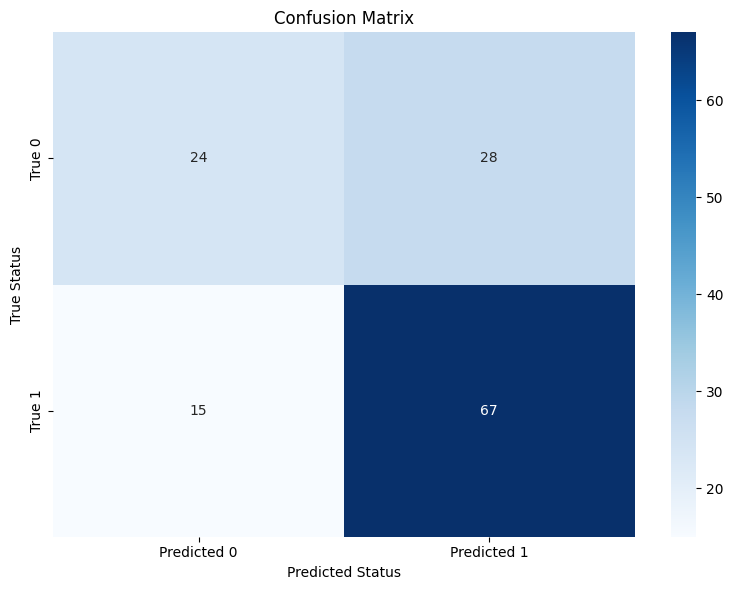

In [80]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== FINAL TEST EVALUATION ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC : {roc_auc_score(y_test, y_pred_proba):.4f}")
print(classification_report(y_test, y_pred))

# Overfitting check
gap = best_score - accuracy_score(y_test, y_pred)
print(f"\nValidation-Test Gap: {gap:.4f}")
if abs(gap) < 0.05:
    print("Good generalization.")
elif abs(gap) < 0.10:
    print("Slight overfitting!")
else:
    print("Significant overfitting!!!")


results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_accuracy', ascending=False)
results_df.to_csv("logreg_results_simple.csv", index=False)
print("\nResults saved to logreg_results_simple.csv")

#Confusion Matrix:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Status')
plt.ylabel('True Status')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

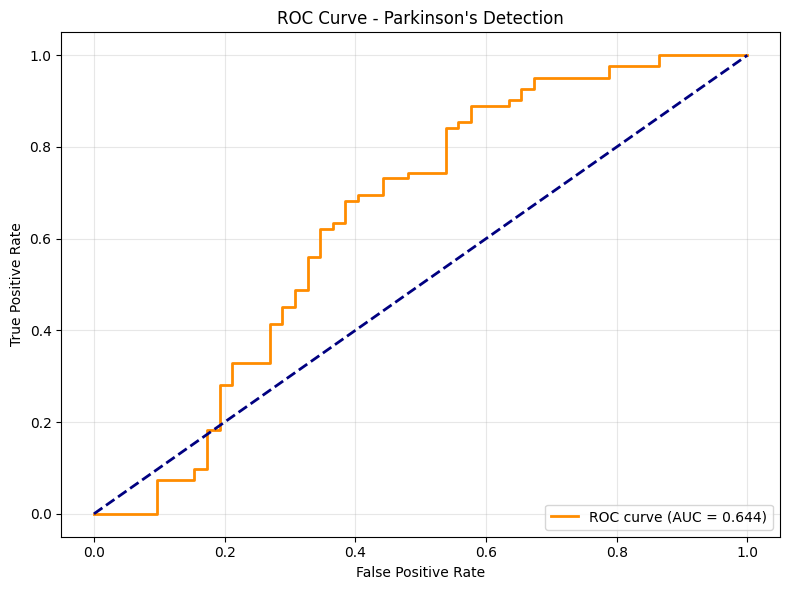


=== TOP 15 FEATURES ===
                                 Feature  Coefficient  Abs_Coefficient
                     Shimmer_apq11^2 HTN    -4.298156         4.298156
Jitter_local Shimmer_local Shimmer_apq11    -4.032208         4.032208
                              Mean_pitch    -3.748133         3.748133
             Jitter_local HTN Mean_pitch     3.702705         3.702705
    Std_pitch Min_pitch Num_voice_breaks    -3.697983         3.697983
                 HTN Std_pitch Min_pitch    -3.182149         3.182149
Frac_unvoiced_frames Degree_voice_breaks     3.168044         3.168044
            Shimmer_local HTN Mean_pitch     3.141946         3.141946
                Jitter_local Min_pitch^2    -2.864720         2.864720
       Mean_pitch^2 Frac_unvoiced_frames     2.753393         2.753393
                        Jitter_local HTN    -2.626767         2.626767
      HTN Mean_pitch Degree_voice_breaks    -2.623828         2.623828
      Jitter_local^2 Degree_voice_breaks    -2.61818

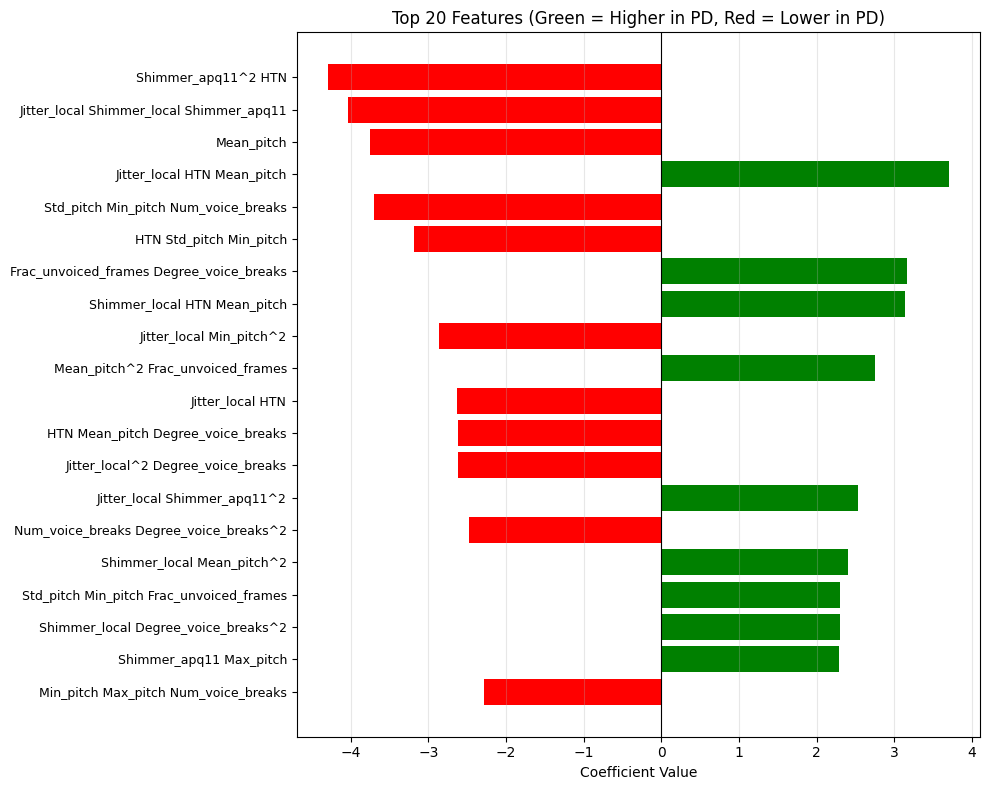

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Parkinson's Detection")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
logreg = best_model.named_steps['logreg']
poly = best_model.named_steps['poly']

if hasattr(poly, 'get_feature_names_out'):
    feature_names = poly.get_feature_names_out()
else:
    feature_names = [f"feature_{i}" for i in range(len(logreg.coef_[0]))]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logreg.coef_[0],
    'Abs_Coefficient': np.abs(logreg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n=== TOP 15 FEATURES ===")
print(coef_df.head(15).to_string(index=False))

# Plot top coefficients
plt.figure(figsize=(10, 8))
top_n = 20
top_coefs = coef_df.head(top_n)
colors = ['red' if x < 0 else 'green' for x in top_coefs['Coefficient']]

plt.barh(range(len(top_coefs)), top_coefs['Coefficient'].values, color=colors)
plt.yticks(range(len(top_coefs)), top_coefs['Feature'].values, fontsize=9)
plt.xlabel('Coefficient Value')
plt.title(f'Top {top_n} Features (Green = Higher in PD, Red = Lower in PD)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Analysis
______________________________________________________________________________________________________________________________________________________

From this we observe that the difference in features from the previous dataset (DFA or RDPE or spread2), these missing features that proved to be vital features in the previous datasets could explain the lower results here. Regardless, our accuracy for class 1 is actually quite high (recall class 1 = 0.82) which is equivalent to our previous dataset total accuracy, so atleast our most important metric is still good (detecting true positives correctly)

We also observe how our most important 15 features when it comes to determining are all multi degree showing that indeed, PD detection is also non-linear in this dataset as well
______________________________________________________________________________________________________________________________________________________

# Section 3: SVM

To continue from our last conclusion, we will do PCB and observe the shape of 2 classes to show that indeed our problem in non-linear:

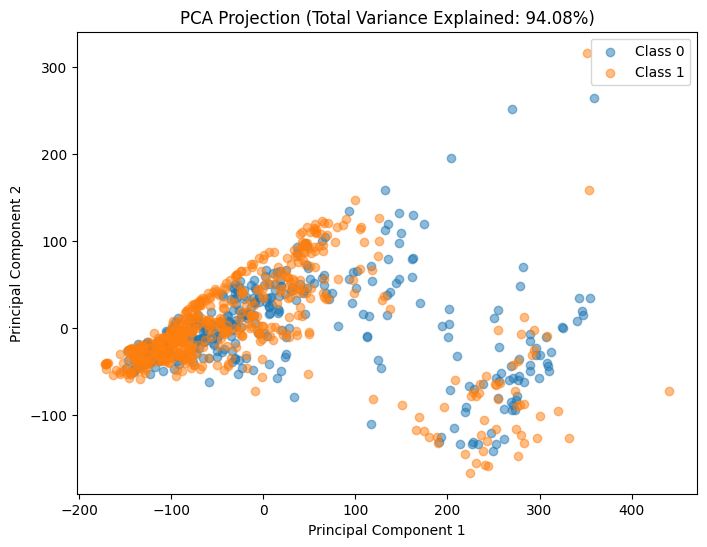

In [87]:
from sklearn.decomposition import PCA
# Fit PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Compute total variance explained
total_var = pca.explained_variance_ratio_.sum() * 100

# Plot PCA projection
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], label='Class 0', alpha=0.5)
plt.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], label='Class 1', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA Projection (Total Variance Explained: {total_var:.2f}%)')
plt.legend()
plt.show()

While we capture only around 89% of the total variane, we can safely assume that our data is not linearly seperable as points from class 1 and 2 fall on top of each other and fail to create distinct clusters, showing that indeed our problem is non-linear.

So it is now clear we'll need a more effective way to capture the non-linear relationship of this dataset, to do so, we will use SVMs. 

We also observe the possibility of outliers as many points are very far from the main cluster, we will proceed normally for now, then attempt to eliminate outliers and try again, to see if possible bad performance is due to some bad data points.

In [139]:
linear_configs = [
    {'kernel': 'linear', 'C': C}
    for C in np.logspace(-3, 3, 16)
]

# RBF (Radial Basis Function): Most popular, handles non-linear patterns well
# gamma controls influence of single training example (low=far, high=close)
rbf_configs = [
    {'kernel': 'rbf', 'C': C, 'gamma': gamma}
    for C in np.logspace(-2, 3, 15)
    for gamma in ['scale', 'auto'] + list(np.logspace(-4, 1, 10))
]

# Polynomial kernel: Captures polynomial relationships (interactions between features)
# degree=2 captures pairwise interactions, degree=3 captures cubic relationships
poly_configs = [
    {'kernel': 'poly', 'degree': degree, 'C': C, 'gamma': gamma, 'coef0': coef0}
    for degree in [2, 3]
    for C in np.logspace(-2, 3, 16)
    for gamma in ['scale', 'auto']
    for coef0 in [0, 1]  # coef0 affects the influence of higher-degree terms
]


all_configs = linear_configs + rbf_configs + poly_configs
print(f"Total configurations to test: {len(all_configs)}\n")

Total configurations to test: 324



And now we fit our models:

In [140]:
from sklearn.svm import SVC
results = []
best_score = 0
best_params = None
best_model = None
print("Training SVM models...")
for i, config in enumerate(all_configs):
    if (i + 1) % 50 == 0:
        print(f"Progress: {i+1}/{len(all_configs)} models trained...")
    
    try:
        # Create pipeline with scaling (critical for SVMs!)
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(probability=True, random_state=42, max_iter=5000, **config))
        ])
        
        # Train and evaluate
        model.fit(X_train, y_train)
        
        val_score = model.score(X_val, y_val)
        train_score = model.score(X_train, y_train)
        
        # Store results
        result = {
            'kernel': config['kernel'],
            'C': config.get('C'),
            'gamma': config.get('gamma'),
            'degree': config.get('degree'),
            'coef0': config.get('coef0'),
            'train_accuracy': train_score,
            'val_accuracy': val_score,
            'train_val_gap': train_score - val_score,
        }
        results.append(result)
        
        # Track best model
        if val_score > best_score:
            best_score = val_score
            best_params = config
            best_model = model
            
    except Exception as e:
        print(f"Failed config {config}: {e}")
        continue

print(f"\nTraining complete!")
print(f"Best Validation Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}\n")

Training SVM models...
Progress: 50/324 models trained...
Progress: 100/324 models trained...
Progress: 150/324 models trained...
Progress: 200/324 models trained...
Progress: 250/324 models trained...
Progress: 300/324 models trained...

Training complete!
Best Validation Score: 0.6989
Best Parameters: {'kernel': 'poly', 'degree': 3, 'C': np.float64(100.0), 'gamma': 'scale', 'coef0': 1}



We observe our test results:

=== PERFORMANCE BY KERNEL TYPE ===
       val_accuracy                 train_val_gap
               mean     max     std          mean
kernel                                           
linear       0.5487  0.6452  0.1386        0.0783
poly         0.6043  0.6989  0.0611        0.0833
rbf          0.5496  0.6882  0.1028        0.1999

=== TOP 3 MODELS PER KERNEL ===

LINEAR Kernel:
        C gamma  degree  val_accuracy  train_val_gap
 0.039811  None     NaN      0.645161       0.028262
25.118864  None     NaN      0.645161      -0.046062
 0.100000  None     NaN      0.639785       0.042647

RBF Kernel:
          C     gamma  degree  val_accuracy  train_val_gap
 439.397056  0.016681     NaN      0.688172       0.118134
 439.397056  0.215443     NaN      0.688172       0.303945
1000.000000  0.215443     NaN      0.688172       0.309576

POLY Kernel:
     C gamma  degree  val_accuracy  train_val_gap
 100.0 scale     3.0      0.698925       0.021796
 100.0  auto     3.0      0.698925       

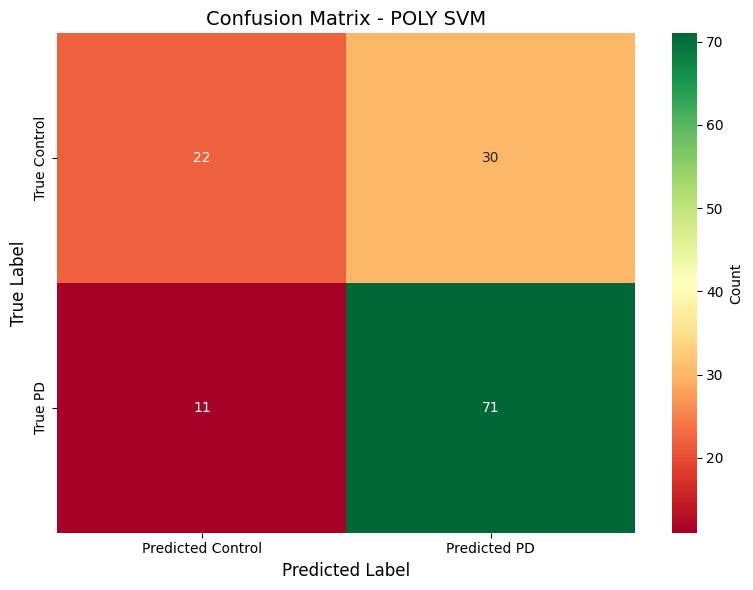

In [141]:

results_df = pd.DataFrame(results)
results_df.to_csv("Ch2_svm_results.csv", index=False)

print("=== PERFORMANCE BY KERNEL TYPE ===")
kernel_summary = results_df.groupby('kernel').agg({
    'val_accuracy': ['mean', 'max', 'std'],
    'train_val_gap': 'mean',
}).round(4)
print(kernel_summary)
print()

print("=== TOP 3 MODELS PER KERNEL ===")
for kernel in results_df['kernel'].unique():
    kernel_df = results_df[results_df['kernel'] == kernel].nlargest(3, 'val_accuracy')
    print(f"\n{kernel.upper()} Kernel:")
    print(kernel_df[['C', 'gamma', 'degree', 'val_accuracy', 'train_val_gap']].to_string(index=False))

#Test evaluation
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
test_acc   = accuracy_score(y_test, y_pred)
test_prec  = precision_score(y_test, y_pred)
test_rec   = recall_score(y_test, y_pred)
test_f1    = f1_score(y_test, y_pred)
test_auc   = roc_auc_score(y_test, y_pred_proba)


print("\n" + "="*60)
print("=== TEST PERFORMANCE SUMMARY ===")
print("="*60)
gap = best_score - accuracy_score(y_test, y_pred)
print(f"\nValidation-Test Gap  : {gap:.4f}")
if abs(gap) < 0.05:
    print("Excellent generalization")
elif abs(gap) < 0.10:
    print("Slight overfitting!")
else:
    print("Significant overfitting!!!")

print(f"\nBest Kernel: {best_params['kernel']}")
print(f"Best C: {best_params.get('C', 'N/A')}")
if 'gamma' in best_params:
    print(f"Best Gamma: {best_params['gamma']}")
if 'degree' in best_params:
    print(f"Best Degree: {best_params['degree']}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Control', 'Parkinson\'s']))

#Confusion Matrix:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', 
            xticklabels=['Predicted Control', 'Predicted PD'],
            yticklabels=['True Control', 'True PD'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - {best_params["kernel"].upper()} SVM', fontsize=14)
plt.tight_layout()
plt.show()



### Analysis
______________________________________________________________________________________________________________________________________________________
We notice that we got marginally better results than simple logistic regression, particularly, we observe that poly kernel did best, with all 3 of the top models outperforming all other SVM models.

The small test-gap suggests we are not overfitting, which is good and bad, meaning we are training our machine correctly, but also we don't seem to have good enough features to get the ideal results we need, and thus don't have any easy way to increase our accuracy from here.

Our recall however did improve slightly, going up to 0.84, which as discussed previously, is our main goal to maximize as it is the most important classifier that needs to be maximized, at the same time, we should not overfit to overguessing 1 in order to achieve this, rather build an accurate machien that guesses true positives more consistently than true negatives.

We also notice that we are likely overfitting on 1 and guessing 1 more than the model should.
______________________________________________________________________________________________________________________________________________________

To tackle the issue of too many 1s, we will do as follows, essentially an F1 scoring scheme:


In [125]:
# Training code
def svexp_best_f1_threshold(y_true, y_prob):
    """Return (threshold, F1) that maximizes F1 on y_prob (class 1 probs)."""
    precisions, recalls, ths = precision_recall_curve(y_true, y_prob)
    if len(ths) == 0:
        return 0.5, 0.0
    f1s = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
    idx = int(np.nanargmax(f1s))
    return float(ths[idx]), float(f1s[idx])

svexp_results = []
svexp_best_val_macro_f1 = -1.0
svexp_best_params = None
svexp_best_model = None

print("Training SVM models...")
for i, svexp_cfg in enumerate(all_configs):
    if (i + 1) % 50 == 0:
        print(f"Progress: {i+1}/{len(all_configs)} models trained...")
    try:
        svexp_pipe = Pipeline([
            ("svexp_scaler", StandardScaler()),
            ("svexp_clf", SVC(probability=True, class_weight='balanced', random_state=42, max_iter=5000, **svexp_cfg))
        ])
        svexp_pipe.fit(X_train, y_train)
        
        # Use standard predict (no threshold tuning needed)
        val_pred = svexp_pipe.predict(X_val)
        train_pred = svexp_pipe.predict(X_train)
        
        # Metrics we'll store
        train_acc = accuracy_score(y_train, train_pred)
        val_acc   = accuracy_score(y_val,   val_pred)
        train_val_gap = train_acc - val_acc
        val_f1_macro = f1_score(y_val,   val_pred, average='macro')
        val_f1_pos   = f1_score(y_val,   val_pred, average='binary', pos_label=1)
        val_prec_pos = precision_score(y_val, val_pred, pos_label=1, zero_division=0)
        val_rec_pos  = recall_score(y_val,  val_pred, pos_label=1, zero_division=0)
        
        svexp_results.append({
            'kernel'           : svexp_cfg.get('kernel'),
            'C'                : svexp_cfg.get('C'),
            'gamma'            : svexp_cfg.get('gamma'),
            'degree'           : svexp_cfg.get('degree'),
            'coef0'            : svexp_cfg.get('coef0'),
            'val_accuracy'     : val_acc,
            'train_val_gap'    : train_val_gap,
            'val_f1_macro'     : val_f1_macro,
            'val_f1_positive'  : val_f1_pos,
            'val_precision_1'  : val_prec_pos,
            'val_recall_1'     : val_rec_pos,
        })
        
        # Select best by macro-F1 for balance across classes
        if val_f1_macro > svexp_best_val_macro_f1:
            svexp_best_val_macro_f1 = val_f1_macro
            svexp_best_params = {**svexp_cfg}
            svexp_best_model = svexp_pipe
            
    except Exception as e:
        print(f"Failed config {svexp_cfg}: {e}")
        continue

print("\nTraining complete!")
print(f"Best Validation Macro-F1: {svexp_best_val_macro_f1:.4f}")
print(f"Best Params: {svexp_best_params}")

Training SVM models...
Progress: 50/388 models trained...
Progress: 100/388 models trained...
Progress: 150/388 models trained...
Progress: 200/388 models trained...
Progress: 250/388 models trained...
Progress: 300/388 models trained...
Progress: 350/388 models trained...

Training complete!
Best Validation Macro-F1: 0.7520
Best Params: {'kernel': 'poly', 'degree': 4, 'C': np.float64(100.0), 'gamma': 'scale', 'coef0': 1}


In [129]:
# Training code
def svexp_best_f1_threshold(y_true, y_prob):
    """Return (threshold, F1) that maximizes F1 on y_prob (class 1 probs)."""
    precisions, recalls, ths = precision_recall_curve(y_true, y_prob)
    if len(ths) == 0:
        return 0.5, 0.0
    f1s = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-12)
    idx = int(np.nanargmax(f1s))
    return float(ths[idx]), float(f1s[idx])

svexp_results = []
svexp_best_val_macro_f1 = -1.0
svexp_best_params = None
svexp_best_model = None

print("Training SVM models...")
for i, svexp_cfg in enumerate(all_configs):
    if (i + 1) % 50 == 0:
        print(f"Progress: {i+1}/{len(all_configs)} models trained...")
    try:
        svexp_pipe = Pipeline([
            ("svexp_scaler", StandardScaler()),
            ("svexp_clf", SVC(probability=True, class_weight='balanced', random_state=42, max_iter=5000, **svexp_cfg))
        ])
        svexp_pipe.fit(X_train, y_train)
        
        # Use standard predict (no threshold tuning needed)
        val_pred = svexp_pipe.predict(X_val)
        train_pred = svexp_pipe.predict(X_train)
        
        # Metrics we'll store
        train_acc = accuracy_score(y_train, train_pred)
        val_acc   = accuracy_score(y_val,   val_pred)
        train_val_gap = train_acc - val_acc
        val_f1_macro = f1_score(y_val,   val_pred, average='macro')
        val_f1_pos   = f1_score(y_val,   val_pred, average='binary', pos_label=1)
        val_prec_pos = precision_score(y_val, val_pred, pos_label=1, zero_division=0)
        val_rec_pos  = recall_score(y_val,  val_pred, pos_label=1, zero_division=0)
        
        svexp_results.append({
            'kernel'           : svexp_cfg.get('kernel'),
            'C'                : svexp_cfg.get('C'),
            'gamma'            : svexp_cfg.get('gamma'),
            'degree'           : svexp_cfg.get('degree'),
            'coef0'            : svexp_cfg.get('coef0'),
            'val_accuracy'     : val_acc,
            'train_val_gap'    : train_val_gap,
            'val_f1_macro'     : val_f1_macro,
            'val_f1_positive'  : val_f1_pos,
            'val_precision_1'  : val_prec_pos,
            'val_recall_1'     : val_rec_pos,
        })
        
        # Select best by macro-F1 for balance across classes
        if val_f1_macro > svexp_best_val_macro_f1:
            svexp_best_val_macro_f1 = val_f1_macro
            svexp_best_params = {**svexp_cfg}
            svexp_best_model = svexp_pipe
            
    except Exception as e:
        print(f"Failed config {svexp_cfg}: {e}")
        continue

print("\nTraining complete!")
print(f"Best Validation Macro-F1: {svexp_best_val_macro_f1:.4f}")
print(f"Best Params: {svexp_best_params}")

Training SVM models...
Progress: 50/388 models trained...
Progress: 100/388 models trained...
Progress: 150/388 models trained...
Progress: 200/388 models trained...
Progress: 250/388 models trained...
Progress: 300/388 models trained...
Progress: 350/388 models trained...

Training complete!
Best Validation Macro-F1: 0.7520
Best Params: {'kernel': 'poly', 'degree': 4, 'C': np.float64(100.0), 'gamma': 'scale', 'coef0': 1}


In [130]:
# Cell 4: Test evaluation
svexp_test_pred = svexp_best_model.predict(X_test)
svexp_test_proba_1 = svexp_best_model.predict_proba(X_test)[:, 1]

svexp_test_acc  = accuracy_score(y_test, svexp_test_pred)
svexp_test_prec = precision_score(y_test, svexp_test_pred, zero_division=0)
svexp_test_rec  = recall_score(y_test, svexp_test_pred, zero_division=0)
svexp_test_f1   = f1_score(y_test, svexp_test_pred)
svexp_test_f1_macro = f1_score(y_test, svexp_test_pred, average='macro')
svexp_test_auc  = roc_auc_score(y_test, svexp_test_proba_1)

print("\n" + "="*60)
print("=== TEST PERFORMANCE SUMMARY ===")
print("="*60)
print(f"Accuracy    : {svexp_test_acc:.4f}")
print(f"Precision   : {svexp_test_prec:.4f}")
print(f"Recall      : {svexp_test_rec:.4f}")
print(f"F1 (binary) : {svexp_test_f1:.4f}")
print(f"F1 (macro)  : {svexp_test_f1_macro:.4f}")
print(f"ROC AUC     : {svexp_test_auc:.4f}")

# Compare validation vs test macro-F1
svexp_val_test_gap = svexp_best_val_macro_f1 - svexp_test_f1_macro
print(f"\nValidation-Test Macro-F1 Gap: {svexp_val_test_gap:.4f}")
if abs(svexp_val_test_gap) < 0.05:
    print("Excellent generalization")
elif abs(svexp_val_test_gap) < 0.10:
    print("Slight overfitting!")
else:
    print("Significant overfitting!!!")

print(f"\nBest Kernel: {svexp_best_params.get('kernel', 'N/A')}")
print(f"Best C: {svexp_best_params.get('C', 'N/A')}")
if 'gamma' in svexp_best_params:
    print(f"Best Gamma: {svexp_best_params['gamma']}")
if 'degree' in svexp_best_params:
    print(f"Best Degree: {svexp_best_params['degree']}")

print("\nClassification Report:")
print(classification_report(y_test, svexp_test_pred, target_names=['Control', "Parkinson's"]))


=== TEST PERFORMANCE SUMMARY ===
Accuracy    : 0.6642
Precision   : 0.6907
Recall      : 0.8171
F1 (binary) : 0.7486
F1 (macro)  : 0.6215
ROC AUC     : 0.6187

Validation-Test Macro-F1 Gap: 0.1305
Significant overfitting!!!

Best Kernel: poly
Best C: 100.0
Best Gamma: scale
Best Degree: 4

Classification Report:
              precision    recall  f1-score   support

     Control       0.59      0.42      0.49        52
 Parkinson's       0.69      0.82      0.75        82

    accuracy                           0.66       134
   macro avg       0.64      0.62      0.62       134
weighted avg       0.65      0.66      0.65       134




=== TEST PERFORMANCE SUMMARY ===
Accuracy    : 0.6642
Precision   : 0.6907
Recall      : 0.8171
F1 (binary) : 0.7486
F1 (macro)  : 0.6215
ROC AUC     : 0.6187

Validation-Test Macro-F1 Gap: 0.1305
Significant overfitting!!!

Best Kernel: poly
Best C: 100.0
Best Gamma: scale
Best Degree: 4

Classification Report:
              precision    recall  f1-score   support

     Control       0.59      0.42      0.49        52
 Parkinson's       0.69      0.82      0.75        82

    accuracy                           0.66       134
   macro avg       0.64      0.62      0.62       134
weighted avg       0.65      0.66      0.65       134


Confusion Matrix Visualization:


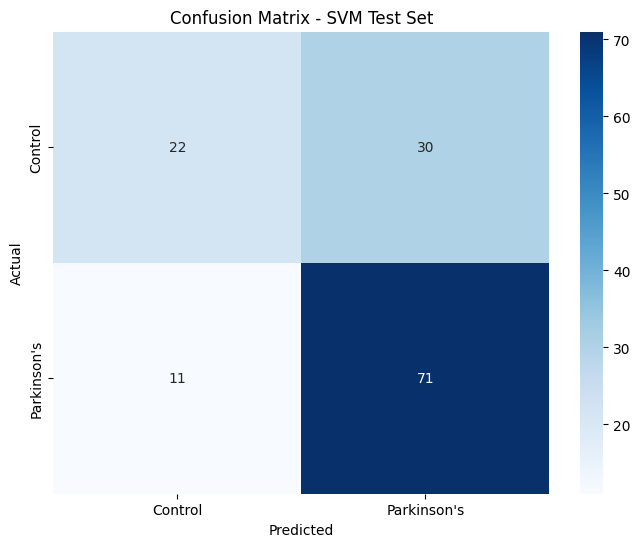

In [144]:
# Cell 4: Test evaluation
svexp_test_pred = svexp_best_model.predict(X_test)
svexp_test_proba_1 = svexp_best_model.predict_proba(X_test)[:, 1]

svexp_test_acc  = accuracy_score(y_test, svexp_test_pred)
svexp_test_prec = precision_score(y_test, svexp_test_pred, zero_division=0)
svexp_test_rec  = recall_score(y_test, svexp_test_pred, zero_division=0)
svexp_test_f1   = f1_score(y_test, svexp_test_pred)
svexp_test_f1_macro = f1_score(y_test, svexp_test_pred, average='macro')
svexp_test_auc  = roc_auc_score(y_test, svexp_test_proba_1)

print("\n" + "="*60)
print("=== TEST PERFORMANCE SUMMARY ===")
print("="*60)
print(f"Accuracy    : {svexp_test_acc:.4f}")
print(f"Precision   : {svexp_test_prec:.4f}")
print(f"Recall      : {svexp_test_rec:.4f}")
print(f"F1 (binary) : {svexp_test_f1:.4f}")
print(f"F1 (macro)  : {svexp_test_f1_macro:.4f}")
print(f"ROC AUC     : {svexp_test_auc:.4f}")

# Compare validation vs test macro-F1
svexp_val_test_gap = svexp_best_val_macro_f1 - svexp_test_f1_macro
print(f"\nValidation-Test Macro-F1 Gap: {svexp_val_test_gap:.4f}")
if abs(svexp_val_test_gap) < 0.05:
    print("Excellent generalization")
elif abs(svexp_val_test_gap) < 0.10:
    print("Slight overfitting!")
else:
    print("Significant overfitting!!!")

print(f"\nBest Kernel: {svexp_best_params.get('kernel', 'N/A')}")
print(f"Best C: {svexp_best_params.get('C', 'N/A')}")
if 'gamma' in svexp_best_params:
    print(f"Best Gamma: {svexp_best_params['gamma']}")
if 'degree' in svexp_best_params:
    print(f"Best Degree: {svexp_best_params['degree']}")

print("\nClassification Report:")
print(classification_report(y_test, svexp_test_pred, target_names=['Control', "Parkinson's"]))
print("\nConfusion Matrix Visualization:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Control', "Parkinson's"],
            yticklabels=['Control', "Parkinson's"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVM Test Set')
plt.show()

We observe, we got much worse results as well as extreme overfitting, clearly trying to balance classes is not only worsening our results as now we are significantly overfitting (as detected above) but also doing worse everywhere in the test set, so we will simply continue with our previous, normal model.

### Back to Normal Model

To see the most important features here, we will use permutation importance (since our best model was a poly SVM) and observe:


=== POLYNOMIAL SVM FEATURE IMPORTANCE ===
Computing permutation importance (this may take a while)...

Top 15 Most Important Features:
             Feature  Importance      Std
                 HTN    0.152151 0.026671
Frac_unvoiced_frames    0.138710 0.020655
       Shimmer_local    0.110215 0.015063
           Std_pitch    0.103763 0.020409
          Mean_pitch    0.088172 0.010257
       Shimmer_apq11    0.068280 0.009928
        Jitter_local    0.039247 0.019392
 Degree_voice_breaks    0.038172 0.015480
           Max_pitch    0.013441 0.013654
    Num_voice_breaks   -0.011828 0.016448
           Min_pitch   -0.063441 0.012447


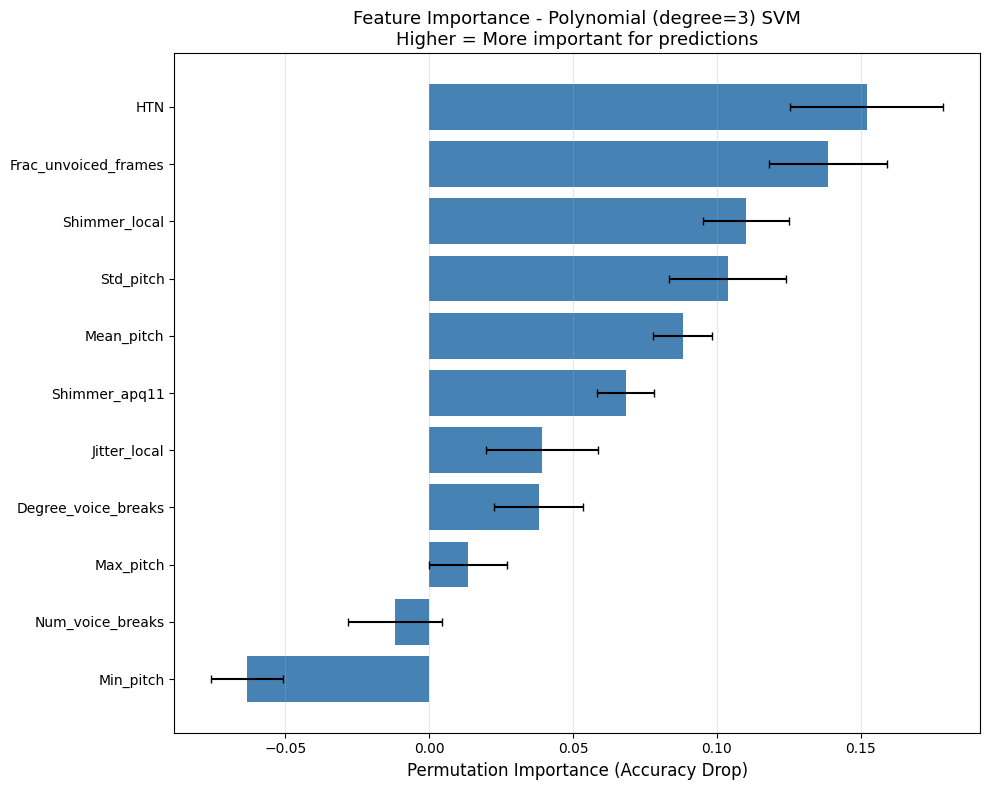

In [145]:
from sklearn.inspection import permutation_importance

# Only run if polynomial kernel won
if best_params['kernel'] == 'poly':
    print("\n=== POLYNOMIAL SVM FEATURE IMPORTANCE ===")
    print("Computing permutation importance (this may take a while)...\n")
    
    # Compute permutation importance on validation set
    perm_importance = permutation_importance(
        best_model, 
        X_val, 
        y_val,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Create dataframe
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Plot
    plt.figure(figsize=(10, 8))
    top_n = 20
    top_features = feature_importance.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['Importance'].values, 
             color='steelblue', xerr=top_features['Std'].values, capsize=3)
    plt.yticks(range(len(top_features)), top_features['Feature'].values, fontsize=10)
    plt.xlabel('Permutation Importance (Accuracy Drop)', fontsize=12)
    plt.title(f'Feature Importance - Polynomial (degree={best_params["degree"]}) SVM\n' + 
              'Higher = More important for predictions', fontsize=13)
    plt.grid(True, alpha=0.3, axis='x')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    

### Analysis And Comparison to Logistic:
______________________________________________________________________________________________________________________________________________________
We notice, while there is overlap in feature importance compared to logistic, we can't really compare 1 to 1, as they differ significantly

They differ because logistic regression with polynomial features explicitly expands and fits coefficients for every interaction term, showing how each combination directly relates to PD.

In contrast, the SVM with a polynomial kernel models these interactions implicitly through the kernel trick and reports each variable’s overall impact on prediction accuracy, not individual term weights.

We also observe that the important features in both models are consistent and do not contradict, they both highlight the same voice changes linked to Parkinson’s, such as increased jitter and shimmer, reduced pitch stability, lower harmonic-to-noise ratio, and more unvoiced frames.
______________________________________________________________________________________________________________________________________________________

## Section 4: Outliers

As observed in the above PCA previuosly, there are probably a lot of outliers that cause these many data points to be away from the main cluster, to deal with this we will use only the train set, remove outliers from it, train and validate on it, then test on the provided test set.

To do this we first set both up:

In [ ]:
from scipy.spatial.distance import mahalanobis
from sklearn.ensemble import IsolationForest
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Define columns to drop
drop_cols = [
    "UPDRS",
    "Jitter_local_absolute", "Jitter_rap", "Jitter_ppq5", "Jitter_ddp",
    "Shimmer_local_dB", "Shimmer_apq3", "Shimmer_apq5", "Shimmer_dda",
    "Mean_period", "Std_period", "Median_pitch",
    "Num_pulses",
    "AC", "NTH",
    "Num_periods"
]

# Drop UPDRS only from train (test doesn't have it)
train_cols_to_drop = [col for col in drop_cols if col in train_data.columns]
test_cols_to_drop = [col for col in drop_cols if col in test_data.columns]

train_data = train_data.drop(columns=train_cols_to_drop)
test_data = test_data.drop(columns=test_cols_to_drop)

print(f"\nAfter dropping columns:")
print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

# Define column names
TARGET_COL = 'Class'
GROUP_COL = 'Subject_id'

# Get feature columns
feature_cols = [col for col in train_data.columns if col not in [TARGET_COL, GROUP_COL]]

print(f"\nTarget: {TARGET_COL}")
print(f"Group: {GROUP_COL}")
print(f"Features ({len(feature_cols)}): {feature_cols}")




In [ ]:
X_train_full = train_data[feature_cols]
y_train_full = train_data[TARGET_COL]
groups_train_full = train_data[GROUP_COL]

X_test = test_data[feature_cols]
y_test = test_data[TARGET_COL]

print(f"X_train_full: {X_train_full.shape}")
print(f"y_train_full: {y_train_full.shape}")
print(f"groups_train_full: {groups_train_full.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

print(f"\nClass distribution in train:")
print(y_train_full.value_counts())
print(y_train_full.value_counts(normalize=True))

print(f"\nClass distribution in test:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

print(f"\nUnique groups in train: {groups_train_full.nunique()}")

In [ ]:
scaler_pca = StandardScaler()
X_scaled_full = scaler_pca.fit_transform(X_train_full)

pca = PCA(n_components=2)
X_pca_full = pca.fit_transform(X_scaled_full)

variance_explained = pca.explained_variance_ratio_.sum()

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca_full[:, 0], X_pca_full[:, 1], 
                     c=y_train_full, cmap='coolwarm', alpha=0.6, s=50)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title(f'PCA Projection Before Outlier Removal\n(Variance Explained: {variance_explained*100:.2f}%)', fontsize=14)
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print("Detecting outliers using Mahalanobis distance...")

mean = np.mean(X_pca_full, axis=0)
cov = np.cov(X_pca_full.T)
inv_cov = np.linalg.inv(cov)

mahal_dist = np.array([mahalanobis(x, mean, inv_cov) for x in X_pca_full])

threshold_mahal = np.percentile(mahal_dist, 95)
outlier_mask_mahal = mahal_dist > threshold_mahal

print(f"Mahalanobis outliers: {outlier_mask_mahal.sum()} ({outlier_mask_mahal.sum()/len(X_train_full)*100:.1f}%)")

In [ ]:
print("Detecting outliers using Isolation Forest...")

iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
outlier_pred = iso_forest.fit_predict(X_scaled_full)
outlier_mask_iso = outlier_pred == -1

print(f"Isolation Forest outliers: {outlier_mask_iso.sum()} ({outlier_mask_iso.sum()/len(X_train_full)*100:.1f}%)")

In [ ]:
outlier_votes = outlier_mask_mahal.astype(int) + outlier_mask_iso.astype(int)
outlier_mask_final = outlier_votes >= 2

print("\n" + "="*60)
print("OUTLIER DETECTION SUMMARY")
print("="*60)
print(f"Outliers detected (2 methods agree): {outlier_mask_final.sum()} ({outlier_mask_final.sum()/len(X_train_full)*100:.1f}%)")
print(f"  Class 0: {outlier_mask_final[y_train_full == 0].sum()}")
print(f"  Class 1: {outlier_mask_final[y_train_full == 1].sum()}")


In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca_full[~outlier_mask_final, 0], X_pca_full[~outlier_mask_final, 1], 
           c=y_train_full[~outlier_mask_final], cmap='coolwarm', alpha=0.6, s=50)
plt.scatter(X_pca_full[outlier_mask_final, 0], X_pca_full[outlier_mask_final, 1],
           c='black', marker='x', s=200, linewidths=3, label='Outliers')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('Outliers Detected', fontsize=13)
plt.legend()
plt.grid(True, alpha=0.3)

X_clean = X_train_full[~outlier_mask_final]
y_clean = y_train_full[~outlier_mask_final]
groups_clean = groups_train_full[~outlier_mask_final]

X_clean_scaled = scaler_pca.fit_transform(X_clean)
X_clean_pca = pca.fit_transform(X_clean_scaled)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_clean_pca[:, 0], X_clean_pca[:, 1],
                     c=y_clean, cmap='coolwarm', alpha=0.6, s=50)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title(f'After Cleaning ({len(X_clean)}/{len(X_train_full)} samples)', fontsize=13)
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCleaned dataset: {len(X_clean)} samples")
print(f"Removed: {outlier_mask_final.sum()} outliers")


In [ ]:
print("\n" + "="*60)
print("SPLITTING DATA")
print("="*60)

sgkf_outer = StratifiedGroupKFold(n_splits=7, shuffle=True, random_state=42)
splits_outer = list(sgkf_outer.split(X_clean, y_clean, groups_clean))
train_val_idx, internal_test_idx = splits_outer[0]

X_train_val = X_clean.iloc[train_val_idx]
y_train_val = y_clean.iloc[train_val_idx]
groups_train_val = groups_clean.iloc[train_val_idx]

X_test_internal = X_clean.iloc[internal_test_idx]
y_test_internal = y_clean.iloc[internal_test_idx]

print(f"First split (internal test):")
print(f"  Train+Val: {len(train_val_idx)/len(X_clean):.2%}")
print(f"  Internal Test: {len(internal_test_idx)/len(X_clean):.2%}")

sgkf_inner = StratifiedGroupKFold(n_splits=9, shuffle=True, random_state=43)
inner_splits = list(sgkf_inner.split(X_train_val, y_train_val, groups_train_val))
train_idx, val_idx = inner_splits[0]

X_train = X_train_val.iloc[train_idx]
y_train = y_train_val.iloc[train_idx]
groups_train = groups_train_val.iloc[train_idx]

X_val = X_train_val.iloc[val_idx]
y_val = y_train_val.iloc[val_idx]
groups_val = groups_train_val.iloc[val_idx]

train_pct = len(X_train) / len(X_clean)
val_pct = len(X_val) / len(X_clean)
test_internal_pct = len(X_test_internal) / len(X_clean)

print(f"\nFinal split:")
print(f"  Train: {train_pct:.2%} ({len(X_train)} samples)")
print(f"  Val:   {val_pct:.2%} ({len(X_val)} samples)")
print(f"  Test:  {test_internal_pct:.2%} ({len(X_test_internal)} samples)")

print(f"\nClass balance:")
print(f"  Train: {y_train.mean():.3f}")
print(f"  Val:   {y_val.mean():.3f}")
print(f"  Internal Test: {y_test_internal.mean():.3f}")

print(f"\nGroup counts:")
print(f"  Train unique groups: {groups_train.nunique()}")
print(f"  Val unique groups:   {groups_val.nunique()}")

In [ ]:
print("\n" + "="*60)
print("SVM CONFIGURATIONS")
print("="*60)

linear_configs = [
    {'kernel': 'linear', 'C': C}
    for C in np.logspace(-3, 2, 12)
]

rbf_configs = [
    {'kernel': 'rbf', 'C': C, 'gamma': gamma}
    for C in np.logspace(-2, 2, 10)
    for gamma in ['scale', 'auto'] + list(np.logspace(-4, 0, 5))
]

poly_configs = [
    {'kernel': 'poly', 'degree': degree, 'C': C, 'gamma': gamma, 'coef0': coef0}
    for degree in [2, 3]
    for C in np.logspace(-2, 2, 8)
    for gamma in ['scale', 'auto']
    for coef0 in [0, 1]
]

sigmoid_configs = [
    {'kernel': 'sigmoid', 'C': C, 'gamma': gamma, 'coef0': coef0}
    for C in np.logspace(-2, 2, 8)
    for gamma in ['scale', 'auto']
    for coef0 in [-1, 0, 1]
]

all_configs = linear_configs + rbf_configs + poly_configs + sigmoid_configs

print(f"Linear:  {len(linear_configs)}")
print(f"RBF:     {len(rbf_configs)}")
print(f"Poly:    {len(poly_configs)}")
print(f"Sigmoid: {len(sigmoid_configs)}")
print(f"TOTAL:   {len(all_configs)}")

In [ ]:
print("\n" + "="*60)
print("TRAINING MODELS")
print("="*60)

results = []
best_score = 0
best_params = None
best_model = None


for i, config in enumerate(all_configs):
    if (i + 1) % 50 == 0:
        print(f"Progress: {i+1}/{len(all_configs)}")
    
    try:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(probability=True, random_state=42, max_iter=5000, **config))
        ])
        
        model.fit(X_train, y_train)
        
        val_score = model.score(X_val, y_val)
        train_score = model.score(X_train, y_train)
        
        result = {
            'kernel': config['kernel'],
            'C': config.get('C'),
            'gamma': config.get('gamma'),
            'degree': config.get('degree'),
            'coef0': config.get('coef0'),
            'train_accuracy': train_score,
            'val_accuracy': val_score,
            'train_val_gap': train_score - val_score,
        }
        results.append(result)
        
        if val_score > best_score:
            best_score = val_score
            best_params = config
            best_model = model
            
    except Exception as e:
        print(f"Failed config {config}: {e}")
        continue

print(f"\nTraining complete")
print(f"Best Validation Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")


In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv("svm_results.csv", index=False)

print("\n" + "="*60)
print("KERNEL PERFORMANCE SUMMARY")
print("="*60)

kernel_summary = results_df.groupby('kernel').agg({
    'val_accuracy': ['mean', 'max', 'std'],
    'train_val_gap': 'mean',
    'train_time': 'mean'
}).round(4)

print(kernel_summary)

In [ ]:
print("\n" + "="*60)
print("TOP 3 MODELS PER KERNEL")
print("="*60)

for kernel in results_df['kernel'].unique():
    kernel_df = results_df[results_df['kernel'] == kernel].nlargest(3, 'val_accuracy')
    print(f"\n{kernel.upper()} Kernel:")
    display_cols = ['C', 'gamma', 'degree', 'val_accuracy', 'train_val_gap']
    available_cols = [col for col in display_cols if col in kernel_df.columns]
    print(kernel_df[available_cols].to_string(index=False))


In [ ]:
print("\n" + "="*60)
print("EVALUATION ON ORIGINAL TEST SET")
print("="*60)

y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f"Best Validation Score: {best_score:.4f}")
print(f"Test Accuracy:         {test_accuracy:.4f}")
print(f"Test ROC-AUC:          {test_roc_auc:.4f}")

gap = best_score - test_accuracy
print(f"\nValidation-Test Gap:   {gap:.4f}")

if abs(gap) < 0.05:
    print("Excellent generalization")
elif abs(gap) < 0.10:
    print("Slight overfitting")
else:
    print("Significant overfitting")

print(f"\nBest Configuration:")
print(f"  Kernel: {best_params['kernel']}")
print(f"  C: {best_params.get('C', 'N/A')}")
if 'gamma' in best_params:
    print(f"  Gamma: {best_params['gamma']}")
if 'degree' in best_params:
    print(f"  Degree: {best_params['degree']}")

print("\nClassification Report (Original Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Control', 'PD']))

In [ ]:
print("\n" + "="*60)
print("EVALUATION ON INTERNAL TEST SET (CLEANED)")
print("="*60)

y_pred_internal = best_model.predict(X_test_internal)
y_pred_proba_internal = best_model.predict_proba(X_test_internal)[:, 1]

test_internal_accuracy = accuracy_score(y_test_internal, y_pred_internal)
test_internal_roc_auc = roc_auc_score(y_test_internal, y_pred_proba_internal)

print(f"Best Validation Score: {best_score:.4f}")
print(f"Test Accuracy:         {test_internal_accuracy:.4f}")
print(f"Test ROC-AUC:          {test_internal_roc_auc:.4f}")

gap_internal = best_score - test_internal_accuracy
print(f"\nValidation-Test Gap:   {gap_internal:.4f}")

if abs(gap_internal) < 0.05:
    print("Excellent generalization")
elif abs(gap_internal) < 0.10:
    print("Slight overfitting")
else:
    print("Significant overfitting")

print("\nClassification Report (Internal Test Set):")
print(classification_report(y_test_internal, y_pred_internal, target_names=['Control', 'PD']))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_original = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='RdYlGn', ax=axes[0],
            xticklabels=['Pred Control', 'Pred PD'],
            yticklabels=['True Control', 'True PD'])
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
axes[0].set_title(f'Original Test Set\nAccuracy: {test_accuracy:.3f}', fontsize=13)

cm_internal = confusion_matrix(y_test_internal, y_pred_internal)
sns.heatmap(cm_internal, annot=True, fmt='d', cmap='RdYlGn', ax=axes[1],
            xticklabels=['Pred Control', 'Pred PD'],
            yticklabels=['True Control', 'True PD'])
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)
axes[1].set_title(f'Internal Test Set\nAccuracy: {test_internal_accuracy:.3f}', fontsize=13)

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fpr_orig, tpr_orig, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc_orig = auc(fpr_orig, tpr_orig)

axes[0].plot(fpr_orig, tpr_orig, color='darkorange', lw=2.5,
            label=f'ROC (AUC = {roc_auc_orig:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[0].fill_between(fpr_orig, tpr_orig, alpha=0.2, color='orange')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC - Original Test Set', fontsize=13)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

fpr_int, tpr_int, _ = roc_curve(y_test_internal, y_pred_proba_internal)
roc_auc_int = auc(fpr_int, tpr_int)

axes[1].plot(fpr_int, tpr_int, color='green', lw=2.5,
            label=f'ROC (AUC = {roc_auc_int:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[1].fill_between(fpr_int, tpr_int, alpha=0.2, color='green')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC - Internal Test Set', fontsize=13)
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

kernel_scores = results_df.groupby('kernel')['val_accuracy'].apply(list)
axes[0, 0].boxplot([kernel_scores[k] for k in kernel_scores.index],
                    labels=[k.upper() for k in kernel_scores.index])
axes[0, 0].set_ylabel('Validation Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy Distribution by Kernel', fontsize=12)
axes[0, 0].axhline(y=best_score, color='r', linestyle='--', alpha=0.5, label='Best')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

kernel_gaps = results_df.groupby('kernel')['train_val_gap'].apply(list)
axes[0, 1].boxplot([kernel_gaps[k] for k in kernel_gaps.index],
                    labels=[k.upper() for k in kernel_gaps.index])
axes[0, 1].set_ylabel('Train-Val Gap', fontsize=11)
axes[0, 1].set_title('Overfitting by Kernel', fontsize=12)
axes[0, 1].axhline(y=0, color='green', linestyle='-', alpha=0.3)
axes[0, 1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

kernel_times = results_df.groupby('kernel')['train_time'].mean()
axes[1, 0].bar(range(len(kernel_times)), kernel_times.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 0].set_xticks(range(len(kernel_times)))
axes[1, 0].set_xticklabels([k.upper() for k in kernel_times.index])
axes[1, 0].set_ylabel('Avg Training Time (s)', fontsize=11)
axes[1, 0].set_title('Training Speed', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')

best_kernel = best_params['kernel']
kernel_df = results_df[results_df['kernel'] == best_kernel].copy()
if 'C' in kernel_df.columns and len(kernel_df) > 1:
    c_groups = kernel_df.groupby('C')['val_accuracy'].mean().sort_index()
    axes[1, 1].semilogx(c_groups.index, c_groups.values, 'o-', linewidth=2, markersize=8)
    axes[1, 1].axvline(x=best_params['C'], color='r', linestyle='--', alpha=0.5,
                       label=f'Best C = {best_params["C"]:.2e}')
    axes[1, 1].set_xlabel('C Parameter', fontsize=11)
    axes[1, 1].set_ylabel('Mean Val Accuracy', fontsize=11)
    axes[1, 1].set_title(f'C Effect ({best_kernel.upper()})', fontsize=12)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("\nGenerating learning curve...")

train_sizes_abs, train_scores_arr, val_scores_arr = learning_curve(
    estimator=Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(probability=True, random_state=42, **best_params))
    ]),
    X=X_train,
    y=y_train,
    cv=5,
    train_sizes=np.linspace(0.2, 1.0, 10),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

train_scores_mean = train_scores_arr.mean(axis=1)
train_scores_std = train_scores_arr.std(axis=1)
val_scores_mean = val_scores_arr.mean(axis=1)
val_scores_std = val_scores_arr.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_scores_mean, 'o-', linewidth=2,
         markersize=8, label='Training score', color='#2ca02c')
plt.plot(train_sizes_abs, val_scores_mean, 'o-', linewidth=2,
         markersize=8, label='CV score', color='#ff7f0e')
plt.fill_between(train_sizes_abs,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.15, color='green')
plt.fill_between(train_sizes_abs,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.15, color='orange')
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title(f'Learning Curve - {best_params["kernel"].upper()} SVM', fontsize=14)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
svm_model = best_model.named_steps['svm']
n_support = svm_model.n_support_

print("\n" + "="*60)
print("SUPPORT VECTORS")
print("="*60)
print(f"Total support vectors: {sum(n_support)}")
print(f"Per class: {n_support}")
print(f"Percentage of training: {sum(n_support)/len(X_train)*100:.1f}%")


In [ ]:
print("\n" + "="*60)
print("PERMUTATION IMPORTANCE")
print("="*60)
print("Computing permutation importance (may take a few minutes)...")

perm_importance = permutation_importance(
    best_model,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(perm_importance_df.head(15).to_string(index=False))

plt.figure(figsize=(10, 8))
top_n = 20
top_perm = perm_importance_df.head(top_n)

plt.barh(range(len(top_perm)), top_perm['Importance'].values,
         color='steelblue', xerr=top_perm['Std'].values, capsize=3)
plt.yticks(range(len(top_perm)), top_perm['Feature'].values, fontsize=10)
plt.xlabel('Permutation Importance (Accuracy Drop)', fontsize=12)
plt.title(f'Feature Importance - {best_params["kernel"].upper()} SVM\nHigher = More Important', fontsize=13)
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
summary = {
    'best_kernel': best_params['kernel'],
    'best_C': best_params.get('C'),
    'best_gamma': best_params.get('gamma'),
    'best_degree': best_params.get('degree'),
    'val_accuracy': best_score,
    'test_accuracy_original': test_accuracy,
    'test_roc_auc_original': test_roc_auc,
    'test_accuracy_internal': test_internal_accuracy,
    'test_roc_auc_internal': test_internal_roc_auc,
    'n_support_vectors': sum(n_support),
    'n_train_samples': len(X_train),
    'n_val_samples': len(X_val),
    'n_test_original': len(X_test),
    'n_test_internal': len(X_test_internal),
    'outliers_removed': outlier_mask_final.sum(),
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('svm_summary.csv', index=False)

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"Best Kernel: {best_params['kernel']}")
print(f"Best C: {best_params.get('C', 'N/A')}")
if 'gamma' in best_params:
    print(f"Best Gamma: {best_params['gamma']}")
if 'degree' in best_params:
    print(f"Best Degree: {best_params['degree']}")
print(f"\nValidation Accuracy: {best_score:.4f}")
print(f"Test Accuracy (Original): {test_accuracy:.4f}")
print(f"Test Accuracy (Internal): {test_internal_accuracy:.4f}")
print(f"\nROC-AUC (Original): {test_roc_auc:.4f}")
print(f"ROC-AUC (Internal): {test_internal_roc_auc:.4f}")
print(f"\nSupport Vectors: {sum(n_support)} ({sum(n_support)/len(X_train)*100:.1f}% of training)")
print(f"Outliers Removed: {outlier_mask_final.sum()}")
print(f"\nResults saved to:")
print("  - svm_results.csv (all configurations)")
print("  - svm_summary.csv (best model summary)")

In [ ]:
print("\n" + "="*60)
print("COMPLETE ANALYSIS SUMMARY")
print("="*60)
print(f"\nDATA:")
print(f"  Original train samples: {len(X_train_full)}")
print(f"  Outliers removed: {outlier_mask_final.sum()}")
print(f"  Final train samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Test samples (original): {len(X_test)}")
print(f"  Test samples (internal): {len(X_test_internal)}")
print(f"  Number of features: {len(feature_cols)}")

print(f"\nBEST MODEL:")
print(f"  Kernel: {best_params['kernel']}")
print(f"  C: {best_params.get('C', 'N/A')}")
if 'gamma' in best_params:
    print(f"  Gamma: {best_params['gamma']}")
if 'degree' in best_params:
    print(f"  Degree: {best_params['degree']}")

print(f"\nPERFORMANCE:")
print(f"  Validation Accuracy: {best_score:.4f}")
print(f"  Test Accuracy (Original): {test_accuracy:.4f}")
print(f"  Test Accuracy (Internal): {test_internal_accuracy:.4f}")
print(f"  Test ROC-AUC (Original): {test_roc_auc:.4f}")
print(f"  Test ROC-AUC (Internal): {test_internal_roc_auc:.4f}")

print(f"\nMODEL CHARACTERISTICS:")
print(f"  Support vectors: {sum(n_support)} ({sum(n_support)/len(X_train)*100:.1f}%)")

print(f"\nTOP 5 IMPORTANT FEATURES:")
for idx, row in perm_importance_df.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

print("\nAnalysis complete")